In [1]:
#! pip install lightgbm

In [84]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors

import lightgbm as lgb
import pickle
import base64

In [35]:
# Reduire la taille des données
def reduce_mem_usage(df):
   
    start_mem = df.memory_usage().sum() / 1024**2
    print('Taille du Dataframe avant traitement {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Taille du Dataframe après traitement: {:.2f} MB'.format(end_mem))
    print('Réduction de {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [67]:
train = reduce_mem_usage(pd.read_csv("../appTrainC_agg_N.csv"))

Taille du Dataframe avant traitement 2871.50 MB
Taille du Dataframe après traitement: 765.97 MB
Réduction de 73.3%


In [68]:
train = train.dropna().sample(5000, random_state=42)

In [81]:
#train.to_csv('finalT.csv', index=False)

In [69]:
train.shape

(5000, 1224)

In [70]:
modelisation = train.drop(['SK_ID_CURR', 'TARGET', 'AMT_GOODS_PRICE'], axis=1)
model_num = modelisation.select_dtypes(exclude=['object', 'category'])
model_cat = modelisation.select_dtypes(include=['object', 'category'])
model_onhot = pd.get_dummies(model_cat, drop_first=True)

model = pd.concat([train['SK_ID_CURR'],model_num, model_onhot], axis=1)

In [71]:
#train.sample(10000, random_state=42)
#train.dropna().to_csv("../trainnotNa.csv", index=False)
#model.to_csv('final.csv', index=False)

In [72]:
X = model
y = train['TARGET']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [74]:
#X_test

In [75]:
y_test

221417    0
118212    0
290294    0
214372    1
28256     0
         ..
146191    0
277575    0
299426    0
217321    0
152832    0
Name: TARGET, Length: 1000, dtype: int8

In [76]:
#X_test

In [77]:
#X_test.to_csv('test.csv', index=False)

In [78]:
#test = pd.read_csv('test.csv')

#client = sorted(test['SK_ID_CURR'].unique())


load_clf = pickle.load(open('clf.pkl', 'rb'))

In [80]:
load_clf.predict(X_test.loc[:,"CNT_CHILDREN" :])

array([0, 0, 1, ..., 0, 1, 0], dtype=int8)

In [48]:
ID = 307213

In [49]:
test.loc[test['SK_ID_CURR']== ID, "CNT_CHILDREN" :]

NameError: name 'test' is not defined

In [51]:
train.dropna().shape

(224828, 1224)

In [52]:
model.dropna().shape

(225430, 1300)

In [55]:
#train.dropna().sample(5000, random_state=42).to_csv('finalT.csv', index=False)
#model.dropna().sample(5000, random_state=42).to_csv('final.csv', index=False)

In [18]:
valMaxi = train["AMT_INCOME_TOTAL"].describe()['75%']

In [19]:
train["AMT_INCOME_TOTAL"].describe()

count    3.074950e+05
mean     1.687382e+05
std      2.371816e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.468125e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [20]:
trainNondef = train[train["TARGET"]==0]

Text(0.5, 1.0, 'poids du crédit sur le revenus')

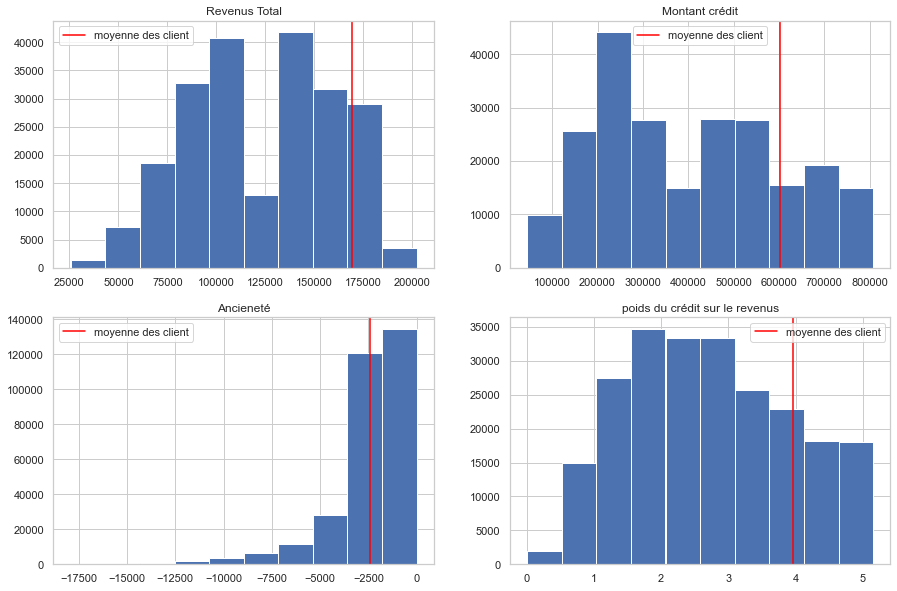

In [21]:
plt.figure(figsize=(15,10))
valMaxi = train["AMT_INCOME_TOTAL"].describe()['75%']
plt.subplot(2, 2, 1)
train.loc[train["AMT_INCOME_TOTAL"]<valMaxi,"AMT_INCOME_TOTAL"].hist()
plt.axvline(trainNondef["AMT_INCOME_TOTAL"].mean(), color='red', label="moyenne des client")
plt.legend()
plt.title("Revenus Total")

valMaxi = train["AMT_CREDIT"].describe()['75%']
plt.subplot(2, 2, 2)
train.loc[train["AMT_CREDIT"]<valMaxi,"AMT_CREDIT"].hist()
plt.axvline(trainNondef["AMT_CREDIT"].mean(), color='red', label="moyenne des client")
plt.legend()
plt.title("Montant crédit")

plt.subplot(2, 2, 3)
valMaxi = train["DAYS_EMPLOYED"].describe()['max']
train.loc[train["DAYS_EMPLOYED"]<valMaxi,"DAYS_EMPLOYED"].hist()
plt.axvline(trainNondef["DAYS_EMPLOYED"].astype('float64').mean(), color='red', label="moyenne des client")
plt.legend()
plt.title("Ancieneté")

plt.subplot(2, 2, 4)
valMaxi = train["credSURrevenu"].describe()['75%']
train.loc[train["credSURrevenu"]<valMaxi,"credSURrevenu"].hist()
plt.axvline(trainNondef["credSURrevenu"].astype('float64').mean(), color='red', label="moyenne des client")
plt.legend()
plt.title("poids du crédit sur le revenus")

In [22]:
trainNondef["credSURrevenu"].astype('float64').mean()

3.9638173388115656

In [23]:
trainNondef["credSURrevenu"].describe()

count    282670.000000
mean               NaN
std           0.000000
min           0.037506
25%           2.000000
50%           3.267578
75%           5.191406
max          49.218750
Name: credSURrevenu, dtype: float64

In [24]:
trainNondef["FL"].describe()

KeyError: 'FL'

In [25]:
#trainNondef.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282670 entries, 1 to 307494
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  282670 non-null  int32   
 1   TARGET                      282670 non-null  int8    
 2   NAME_CONTRACT_TYPE          282670 non-null  category
 3   CODE_GENDER                 282670 non-null  category
 4   FLAG_OWN_CAR                282670 non-null  category
 5   FLAG_OWN_REALTY             282670 non-null  category
 6   CNT_CHILDREN                282670 non-null  int8    
 7   AMT_INCOME_TOTAL            282670 non-null  float32 
 8   AMT_CREDIT                  282670 non-null  float32 
 9   AMT_ANNUITY                 282670 non-null  float32 
 10  AMT_GOODS_PRICE             282670 non-null  float32 
 11  NAME_INCOME_TYPE            282670 non-null  category
 12  NAME_EDUCATION_TYPE         282670 non-null  category
 13 

In [19]:
#train["NAME_FAMILY_STATUS"].unique()

NameError: name 'train' is not defined

In [33]:
#%reset -f

In [93]:
#neigh = NearestNeighbors(n_neighbors=5)

In [96]:
#X_fit = X.loc[:,"CNT_CHILDREN" :].dropna(axis=1)

In [97]:
#neigh.fit(X_fit.to_numpy())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').